In [1]:
%matplotlib inline
import numpy as np
from scipy.special import gamma
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rc("text", usetex=True)
matplotlib.rc("font", family="serif")
matplotlib.style.use("dark_background")

In [3]:
def vol(n):
    return np.pi**(n / 2) / gamma(n / 2 + 1)

def square(n):
    return 2**n

In [4]:
dimensions = []
vol_ratios = []
for n in range(2, 20):
    dimensions.append(n)
    vol_ratios.append(vol(n) / square(n))

In [5]:
print(vol_ratios)

[0.7853981633974483, 0.5235987755982989, 0.30842513753404244, 0.16449340668482262, 0.08074551218828077, 0.03691223414321407, 0.0158543442438155, 0.006442400200661536, 0.00249039457019272, 0.0009199725973583495, 0.00032599188692738996, 0.00011116073666788121, 3.657620418217724e-05, 1.1640725122781505e-05, 3.590860448591509e-06, 1.0756004861231918e-06, 3.13361689037812e-07, 8.89236469842692e-08]


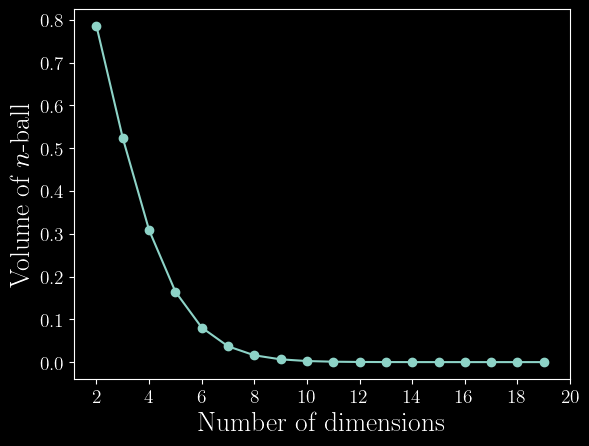

In [6]:
fig = plt.figure()
ax = plt.gca()
ax.plot(dimensions, vol_ratios, marker="o")
ax.set_xlabel("Number of dimensions", fontsize=20)
ax.set_ylabel("Volume of $n$-ball", fontsize=20)
ax.set_xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
ax.tick_params(axis="both", labelsize=14)

fig.savefig("nball.pdf", bbox_inches="tight", transparent=True)

# MCMC

In [7]:
import emcee

In [8]:
def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

In [9]:
ndim = 5
rng = np.random.default_rng(42)
means = rng.random(ndim)

cov = 0.5 - rng.random(ndim**2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)

In [10]:
nwalkers = 32
p0 = rng.random((nwalkers, ndim))

In [11]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

In [12]:
log_prob(p0[0], means, cov)

-9.668351347209105

In [13]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [14]:
sampler.run_mcmc(state, 10000);

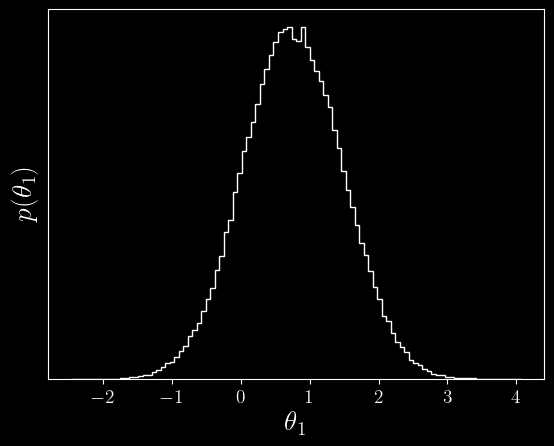

In [15]:
samples = sampler.get_chain(flat=True)

fig = plt.figure()
ax = plt.gca()
ax.hist(samples[:, 0], 100, color="w", histtype="step")
ax.set_xlabel(r"$\theta_1$", fontsize=20)
ax.set_ylabel(r"$p(\theta_1)$", fontsize=20)
ax.set_yticks([])
ax.tick_params(axis="both", labelsize=14)

In [16]:
print(
    "Mean acceptance fraction: {0:0.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.551


# More Complicated Example

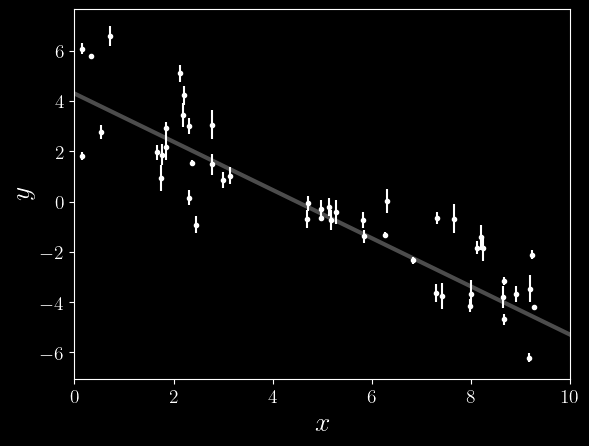

In [17]:
rng = np.random.default_rng(123)

# define "true" parameters
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# generate some synthetic data
N = 50
x = np.sort(10 * rng.random(N))
yerr = 0.1 + 0.5 * rng.random(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * rng.standard_normal(N)
y += yerr * rng.standard_normal(N)

fig = plt.figure()
ax = plt.gca()
ax.errorbar(x, y, yerr=yerr, fmt=".w", capsize=0)
x0 = np.linspace(0, 10, num=500)
ax.plot(x0, m_true * x0 + b_true, "w", alpha=0.3, linewidth=3)
ax.set_xlim((0, 10))
ax.set_xlabel(r"$x$", fontsize=20)
ax.set_ylabel(r"$y$", fontsize=20)
ax.tick_params(axis="both", labelsize=14)

## Fit with linear least-squares

Least-squares estimates:
m = -0.955 ± 0.010
b = 4.532 ± 0.060


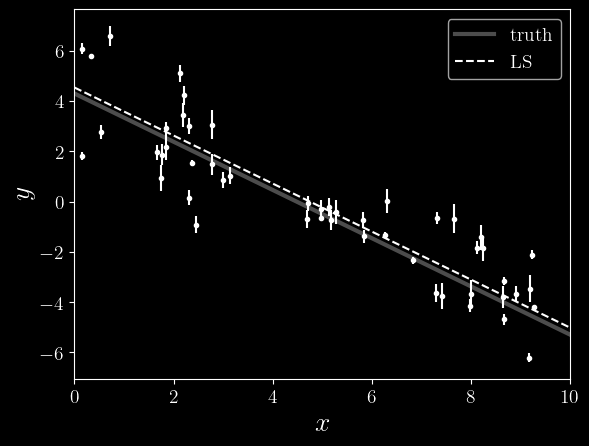

In [18]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

fig = plt.figure()
ax = plt.gca()
ax.errorbar(x, y, yerr=yerr, fmt=".w", capsize=0)
ax.plot(x0, m_true * x0 + b_true, "w", alpha=0.3, lw=3, label="truth")
ax.plot(x0, np.dot(np.vander(x0, 2), w), "--w", label="LS")
ax.legend(fontsize=14)
ax.set_xlim((0, 10))
ax.set_xlabel("$x$", fontsize=20)
ax.set_ylabel("$y$", fontsize=20)
ax.tick_params(axis="both", labelsize=14)

## Maximum Likelihood Estimation (MLE)

In [19]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = -0.881
b = 4.058
f = 0.539


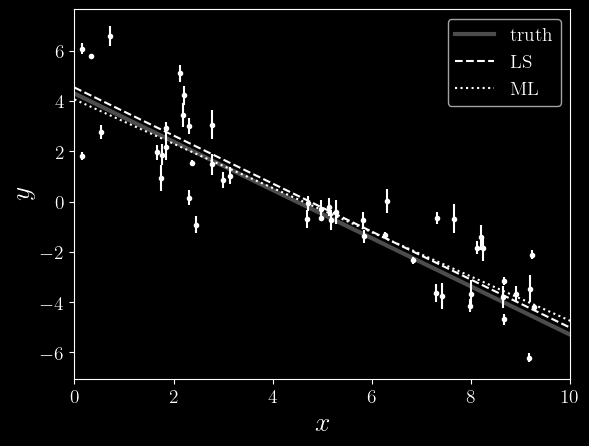

In [20]:
from scipy.optimize import minimize

nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * rng.standard_normal(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

fig = plt.figure()
ax = plt.gca()
ax.errorbar(x, y, yerr=yerr, fmt=".w", capsize=0)
ax.plot(x0, m_true * x0 + b_true, "w", alpha=0.3, lw=3, label="truth")
ax.plot(x0, np.dot(np.vander(x0, 2), w), "--w", label="LS")
ax.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":w", label="ML")
ax.legend(fontsize=14)
ax.set_xlim((0, 10))
ax.set_xlabel(r"$x$", fontsize=20)
ax.set_ylabel(r"$y$", fontsize=20)
ax.tick_params(axis="both", labelsize=14)

## MCMC with `emcee`

In [21]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [22]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [23]:
pos = soln.x + 1e-4 * rng.standard_normal((32, 3))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2718.51it/s]


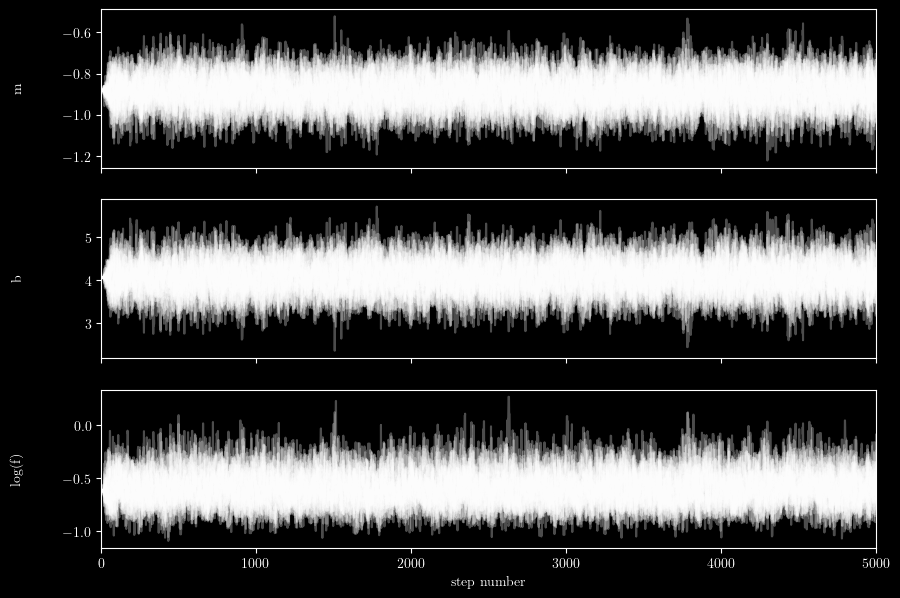

In [24]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "w", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [25]:
tau = sampler.get_autocorr_time()
print(tau)

[35.29510998 36.0687173  35.43499317]


In [26]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


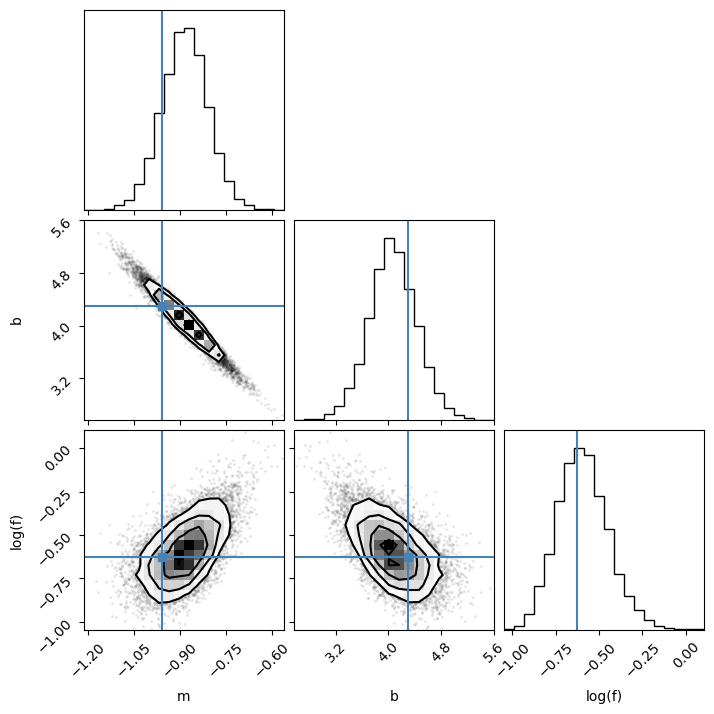

In [27]:
import corner

matplotlib.style.use("default")
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

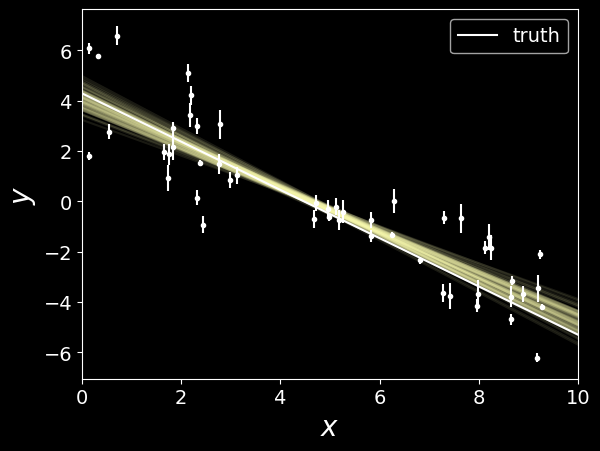

In [28]:
matplotlib.style.use("dark_background")

fig = plt.figure()
ax = plt.gca()

inds = rng.integers(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    ax.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
ax.errorbar(x, y, yerr=yerr, fmt=".w", capsize=0)
ax.plot(x0, m_true * x0 + b_true, "w", label="truth")
ax.legend(fontsize=14)
ax.set_xlim((0, 10))
ax.set_xlabel(r"$x$", fontsize=20)
ax.set_ylabel(r"$y$", fontsize=20)
ax.tick_params(axis="both", labelsize=14)